# Planar data classification with one hidden layer



In [2]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

## 2 - Dataset ##

First, let's get the dataset you will work on. The following code will load a "flower" 2-class dataset into variables `X` and `Y`.

In [ ]:
X, Y = load_planar_dataset()

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. 

In [ ]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);

You have:
    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

Lets first get a better sense of what our data is like. 


In [5]:

shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]  # training set size


print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 200)
The shape of Y is: (1, 200)
I have m = 200 training examples!


## 3 - Simple Logistic Regression

Before building a full neural network, lets first see how logistic regression performs on this problem. You can use sklearn's built-in functions to do that. Run the code below to train a logistic regression classifier on the dataset.

In [6]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

f:\iiits\other\dl\dl\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
f:\iiits\other\dl\dl\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


You can now plot the decision boundary of these models. Run the code below.

Accuracy of logistic regression: 85 % (percentage of correctly labelled datapoints)


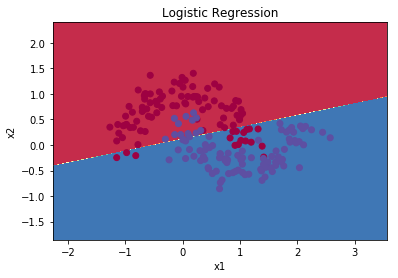

In [7]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y.ravel())
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now! 

## 4 - Neural Network model

Logistic regression did not work well on the "flower dataset". You are going to train a Neural Network with a single hidden layer.

**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

### 4.1 - Defining the neural network structure ####



In [28]:
#layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
  

    n_x = X.shape[0] # size of input layer
    n_h = 4 
    n_y = Y.shape[0] # size of output layer

    return (n_x, n_h, n_y)

In [29]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


### 4.2 - Initialize the model's parameters ####



In [10]:
#  initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [11]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-1.05795222 -0.90900761  0.55145404  2.29220801]]
b2 = [[0.]]


### 4.3 - The Loop ####


In [30]:
#  forward_propagation

def forward_propagation(X, parameters):
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Implement Forward Propagation to calculate A2 (probabilities)
  
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [31]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.26281864019752443 0.09199904522700109 -1.3076660128732143 0.21287768171914198


Now that you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$


In [32]:
# compute_cost

def compute_cost(A2, Y, parameters):
    
    m = Y.shape[1] # number of example

    logprobs = np.multiply(np.log(A2),Y) + np.multiply((1-Y),np.log(1-A2))
    cost = -np.sum(logprobs)
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [33]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 2.079176283118394


In [34]:
#  backward_propagation

def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2-Y
    dW2 = 1/m * (np.dot(dZ2,A1.T))
    db2 = 1/m * (np.sum(dZ2,axis = 1,keepdims = True))
    dZ1 = np.dot(W2.T,dZ2) * (1- np.power(A1,2))
    dW1 = 1/m * (np.dot(dZ1,X.T))
    db1 = 1/m * (np.sum(dZ1,axis = 1,keepdims = True))
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [35]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


In [36]:
#  update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Update rule for each parameter
    W1 = W1- learning_rate * dW1
    b1 = b1- learning_rate * db1
    W2 = W2- learning_rate * dW2
    b2 = b2- learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [37]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


In [38]:
    #  nn_model

    def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
      
        np.random.seed(3)
        n_x = layer_sizes(X, Y)[0]
        n_y = layer_sizes(X, Y)[2]

        # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
        parameters = initialize_parameters(n_x,n_h,n_y)
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']
      
        # Loop (gradient descent)

        for i in range(0, num_iterations):

            # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
            A2, cache = forward_propagation(X,parameters)

            # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
            cost = compute_cost(A2,Y,parameters)

            # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
            grads = backward_propagation(parameters,cache,X,Y)

            # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
            parameters = update_parameters(parameters,grads)

            # Print the cost every 1000 iterations
            if print_cost and i % 1000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))

        return parameters

In [39]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 1.959649
Cost after iteration 1000: 0.000641
Cost after iteration 2000: 0.000320
Cost after iteration 3000: 0.000213
Cost after iteration 4000: 0.000159
Cost after iteration 5000: 0.000127
Cost after iteration 6000: 0.000106
Cost after iteration 7000: 0.000091
Cost after iteration 8000: 0.000079
Cost after iteration 9000: 0.000070
W1 = [[-0.67217213  1.33737914]
 [-0.65598488  1.27247072]
 [ 0.55737732 -1.09668721]
 [ 0.90635375 -2.08077263]]
b1 = [[ 0.15253561]
 [ 0.16843239]
 [-0.1741792 ]
 [ 0.19390201]]
W2 = [[-2.64738303 -2.48746615  1.94802517  4.02291264]]
b2 = [[0.06638778]]


In [40]:
# predict

def predict(parameters, X):
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X,parameters)
    predictions = A2
    
    return predictions

In [41]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.500891384745377


It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

Cost after iteration 0: 135.611041
Cost after iteration 1000: 60.503751
Cost after iteration 2000: 13.003125
Cost after iteration 3000: 11.720057
Cost after iteration 4000: 11.044753
Cost after iteration 5000: 10.586701
Cost after iteration 6000: 10.264323
Cost after iteration 7000: 10.030892
Cost after iteration 8000: 9.855789
Cost after iteration 9000: 9.719690


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

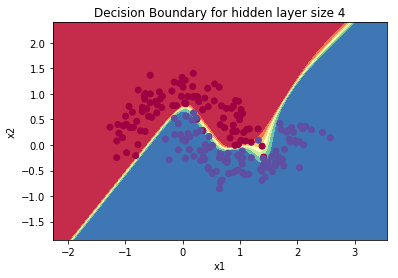

In [42]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())
plt.title("Decision Boundary for hidden layer size " + str(4))


**Expected Output**:

<table style="width:40%">
  <tr>
    <td>**Cost after iteration 9000**</td>
    <td> 0.218607 </td> 
  </tr>
  
</table>


In [43]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 96%


### 4.6 - Tuning hidden layer size  ###


Accuracy for 1 hidden units: 80.62931256613948 %
Accuracy for 2 hidden units: 83.95831990523916 %
Accuracy for 3 hidden units: 96.32699366405369 %
Accuracy for 4 hidden units: 96.55774198638852 %
Accuracy for 5 hidden units: 96.54044489522204 %
Accuracy for 20 hidden units: 96.4742573627978 %
Accuracy for 50 hidden units: 97.05811197888696 %


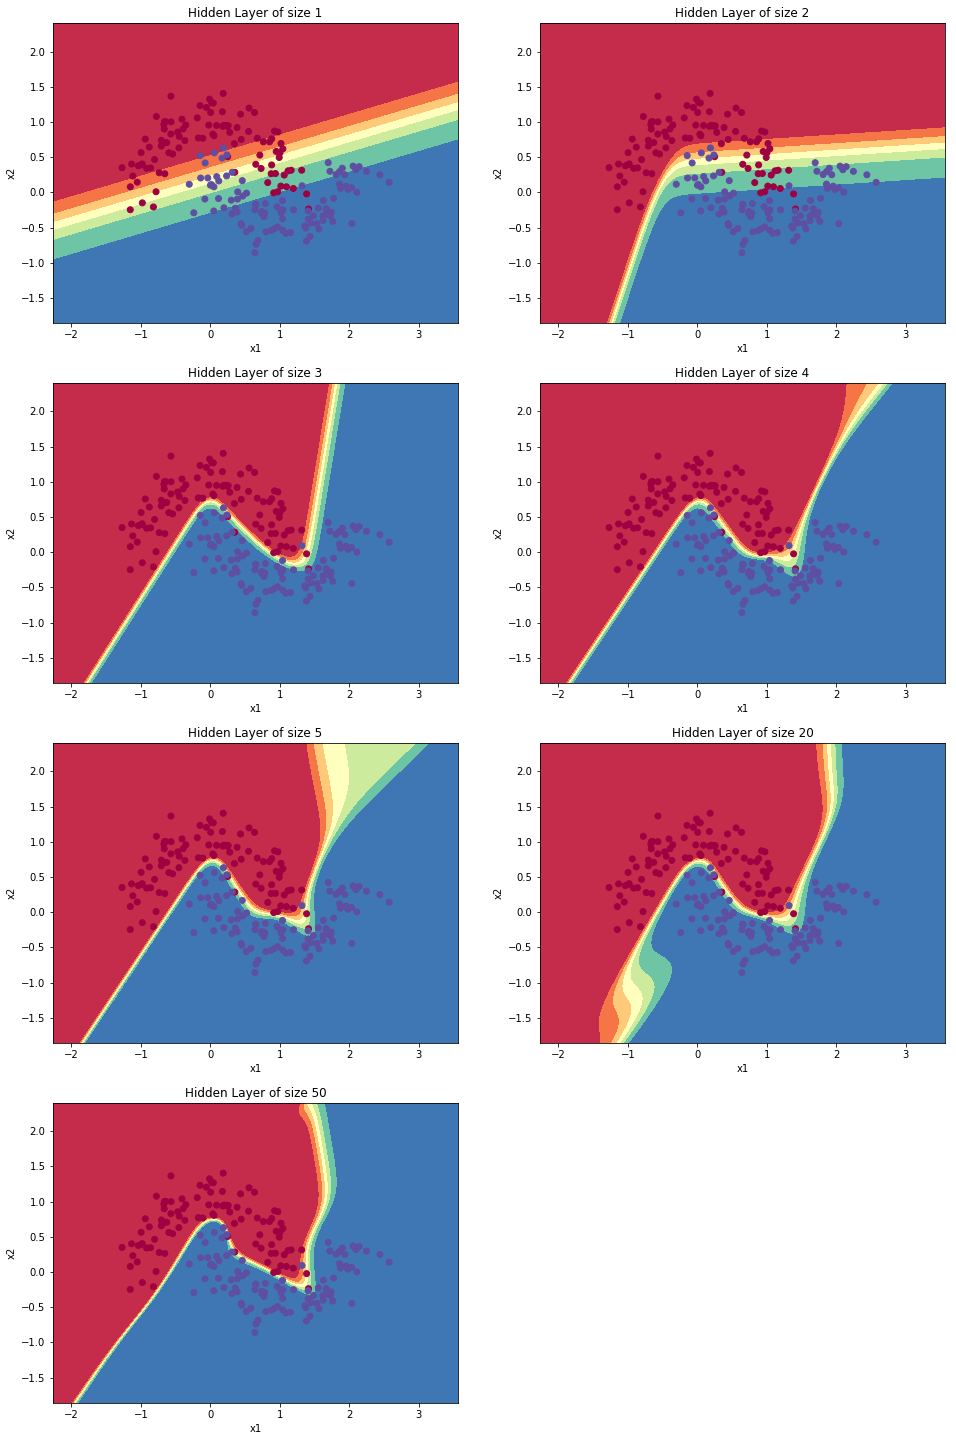

In [44]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

## 5) Performance on other datasets

If you want, you can rerun the whole notebook (minus the dataset part) for each of the following datasets.

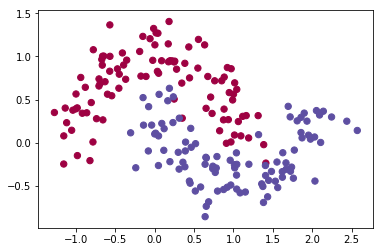

In [4]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);